### On the 11th of July, 2020, I started an NLP competition on Kaggle. This is part of my topdown approach to learning Natural Language Processing

**In this competition, one’s is challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t**

*Often, I collect the datasets & store in my local machine, look for a notebook in the Kaggle notebook section, and use it as a guide. I read each cell and research on why the author used the codes in each cell.*

Link to the Kaggle Notebook: https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

**Getting Started**

*import modules*

In [73]:
import gc # provides an interface to the optional garbage collector.
# The process by which Python periodically frees and reclaims blocks 
#of memory that no longer are in use is called Garbage Collection
import re # This module provides regular expression matching operations
import string # This module contains a number of functions to process standard Python strings
import operator # The operator module exports a set of efficient functions corresponding to the 
#intrinsic operators of Python.
from collections import defaultdict # This module implements specialized container datatypes 
#providing alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple

import numpy as np # Numerical python
import pandas as pd # Data Analysis

# lets you customize some aspects of its behaviour, display-related options being those the user
#is most likely to adjust
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Visualization modules
import matplotlib.pyplot as plt 
import seaborn as sns


import tokenization # A general purpose text tokenizing module for python
from wordcloud import STOPWORDS # Module with common stop words

# Provides train/test indices to split data in train/test sets
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

# An open source software library for high performance numerical computation
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

**The competition objective:**

*In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified*

**Reading the train and test dataset**👇🏽

In [74]:
train = pd.read_csv('train.csv', dtype={'id': np.int16, 'target': np.int8})
test = pd.read_csv('test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


In [75]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [76]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


**Handling Missing Values**

*If you eyeball the first 5 data points, it's obvious the keyword & location columns have NaN values* 

In [77]:
# Checking for null values using the isnull function
train.isnull().head()

,id,keyword,location,text,target
0,False,True,True,False,False
1,False,True,True,False,False
2,False,True,True,False,False
3,False,True,True,False,False
4,False,True,True,False,False


In [78]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [79]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

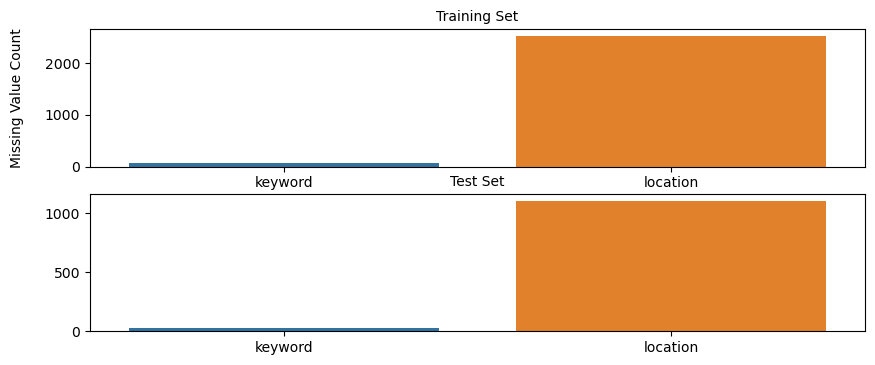

In [68]:
missingColumns = ['keyword', 'location'] 

# plot the distribution of the missing values in the train & test set
fig, axes = plt.subplots(nrows=2, figsize=(10,4), dpi=100) 

sns.barplot(x=train[missingColumns].isnull().sum().index, 
           y=train[missingColumns].isnull().sum().values, ax=axes[0])
sns.barplot(x=test[missingColumns].isnull().sum().index, 
           y=test[missingColumns].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=10, labelpad=15)
axes[0].tick_params(axis='x', labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)
axes[1].tick_params(axis='x', labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)

axes[0].set_title('Training Set', fontsize=10)
axes[1].set_title('Test Set', fontsize=10)

plt.show()    

In [69]:
# The train & test set seem to have the same amount of missing values
# Missing values in those features are filled with no_keyword and no_location respectively.
for df in [train, test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no{col}') 

In [70]:
print(train.head())
print('_______________________________________________________________________________________')
test.head()

   id    keyword    location                                               text  target
0   1  nokeyword  nolocation  Our Deeds are the Reason of this #earthquake M...       1
1   4  nokeyword  nolocation             Forest fire near La Ronge Sask. Canada       1
2   5  nokeyword  nolocation  All residents asked to 'shelter in place' are ...       1
3   6  nokeyword  nolocation  13,000 people receive #wildfires evacuation or...       1
4   7  nokeyword  nolocation  Just got sent this photo from Ruby #Alaska as ...       1
_______________________________________________________________________________________


,id,keyword,location,text
0,0,nokeyword,nolocation,Just happened a terrible car crash
1,2,nokeyword,nolocation,"Heard about #earthquake is different cities, s..."
2,3,nokeyword,nolocation,"there is a forest fire at spot pond, geese are..."
3,9,nokeyword,nolocation,Apocalypse lighting. #Spokane #wildfires
4,11,nokeyword,nolocation,Typhoon Soudelor kills 28 in China and Taiwan
